# MNIST Dataset, Genetic Algorithms and Neural Networks

What is the MNIST dataset? Simply put, it is 70000 black and white images of handwritten digits.

Where is it available?

To begin, let's import the MNIST dataset.

For this notebook, we'll use scikit-learn and sklearn-deap for our computations, and plotly, seaborn and matplotlib for visualizations.

In [1]:
import plotly
plotly.offline.init_notebook_mode()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [3]:
from sklearn.datasets import fetch_mldata
import tempfile
from six.moves import urllib
import pickle, os

if os.path.exists('mnist.p') == 0 or os.stat('mnist.p').st_size == 0:
    test_data_home = tempfile.mkdtemp()
    try:
        mnist = fetch_mldata('MNIST original',data_home=test_data_home)
    except:
        from scipy.io import loadmat
        mnist_alternative_url = "https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat"
        mnist_path = "./mnist-original.mat"
        response = urllib.request.urlopen(mnist_alternative_url)
        with open(mnist_path, "wb") as f:
            content = response.read()
            f.write(content)
        mnist_raw = loadmat(mnist_path)
        mnist = {
            "data": mnist_raw["data"].T,
            "target": mnist_raw["label"][0],
            "COL_NAMES": ["label", "data"],
            "DESCR": "mldata.org dataset: mnist-original",
        }
    pickle.dump(mnist,open('mnist.p','wb'))
else:
    mnist = pickle.load(open('mnist.p','rb'))

Now that we've imported the data, let's explore what it looks like.

In [7]:
print(dict(zip(['n_samples/images','n_features/pixels'],mnist.data.shape)))

{'n_samples/images': 70000, 'n_features/pixels': 784}


There are 70000 images contained in the dataset, each with 784 pixels, containing intensity values from 1 to 255. The original images are actually 28 pixels x 28 px square images, so let's reshape one of these images/samples into 28px by 28px and plot a heatmap of this:

In [5]:
import seaborn as sns, matplotlib.pyplot as plt, numpy as np, pandas as pd

(28, 28)


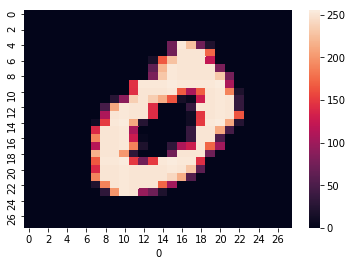

In [9]:
# image 3, a 1x728 dimensional vector of intensity values
image_heatmap_data = mnist.data[3,:].reshape((28,28))
print(image_heatmap_data.shape)

plt.figure()
sns.heatmap(image_heatmap_data)
plt.xlabel(str(int(mnist.target[3])))
plt.show()

Now let's'plot the first 49 digits:

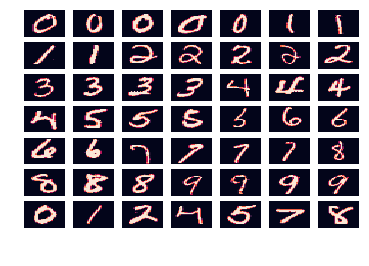

In [29]:
idxs = np.linspace(0,mnist.data.shape[0],50).astype(int)
for i in range(49):
    plt.subplot(7,7,i+1)
    plt.axis('off')
    sns.heatmap(mnist.data[idxs[i],:].reshape((28,28)),cbar=False)
    plt.xlabel(str(int(mnist.target[idxs[i]])))
    
plt.show()

There you go, the MNIST dataset. 70000 images that were originally 28px by 28px images that were turned into 728 px vectors. The images were flattened, and so we have a 70000 by 728 sample by feature matrix, and we can access a digit by loading a particular row of the matrix.

So let's do some machine learning. Let's train a neural network to recognize handwritten digits. First, randomize all of our digits.

In [10]:
shuffled = np.arange(mnist.data.shape[0])
np.random.shuffle(shuffled)
data = mnist.data[shuffled,:]
labels = mnist.target[shuffled]

Then, split them into a training set and testing set. We will train our neural network to recognize these digits, and then test the accuracy on our test set. Consult these videos and text for some explanations:
* https://www.youtube.com/watch?v=aircAruvnKk
* https://www.youtube.com/watch?v=rEDzUT3ymw4
* http://neuralnetworksanddeeplearning.com/chap1.html
* http://natureofcode.com/book/chapter-10-neural-networks/

For this example we will use a multilayer perceptron (MLP):

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data,labels,test_size=0.33, random_state=42)

67% of the digits and labels are devoted to training the data, while 33% of the digits are devoted to testing. We now initialize the MLPClassifier, which we will train using our training set X_train, X_test:

In [26]:
from sklearn.neural_network import MLPClassifier
MLP = MLPClassifier(hidden_layer_sizes=(20,20),activation='tanh',learning_rate='constant')
MLP.fit(X_train,y_train)

MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(20, 20), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [27]:
# Code shout out to Oli Blum: https://stackoverflow.com/questions/29888233/how-to-visualize-a-neural-network
from math import cos, sin, atan


class Neuron():
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def draw(self, neuron_radius):
        circle = plt.Circle((self.x, self.y), radius=neuron_radius, fill=False)
        plt.gca().add_patch(circle)


class Layer():
    def __init__(self, network, number_of_neurons, number_of_neurons_in_widest_layer):
        self.vertical_distance_between_layers = 6
        self.horizontal_distance_between_neurons = 2
        self.neuron_radius = 0.5
        self.number_of_neurons_in_widest_layer = number_of_neurons_in_widest_layer
        self.previous_layer = self.__get_previous_layer(network)
        self.y = self.__calculate_layer_y_position()
        self.neurons = self.__intialise_neurons(number_of_neurons)

    def __intialise_neurons(self, number_of_neurons):
        neurons = []
        x = self.__calculate_left_margin_so_layer_is_centered(number_of_neurons)
        for iteration in range(number_of_neurons):
            neuron = Neuron(x, self.y)
            neurons.append(neuron)
            x += self.horizontal_distance_between_neurons
        return neurons

    def __calculate_left_margin_so_layer_is_centered(self, number_of_neurons):
        return self.horizontal_distance_between_neurons * (self.number_of_neurons_in_widest_layer - number_of_neurons) / 2

    def __calculate_layer_y_position(self):
        if self.previous_layer:
            return self.previous_layer.y + self.vertical_distance_between_layers
        else:
            return 0

    def __get_previous_layer(self, network):
        if len(network.layers) > 0:
            return network.layers[-1]
        else:
            return None

    def __line_between_two_neurons(self, neuron1, neuron2):
        angle = atan((neuron2.x - neuron1.x) / float(neuron2.y - neuron1.y))
        x_adjustment = self.neuron_radius * sin(angle)
        y_adjustment = self.neuron_radius * cos(angle)
        line = plt.Line2D((neuron1.x - x_adjustment, neuron2.x + x_adjustment), (neuron1.y - y_adjustment, neuron2.y + y_adjustment))
        plt.gca().add_line(line)

    def draw(self, layerType=0):
        for neuron in self.neurons:
            neuron.draw( self.neuron_radius )
            if self.previous_layer:
                for previous_layer_neuron in self.previous_layer.neurons:
                    self.__line_between_two_neurons(neuron, previous_layer_neuron)
        # write Text
        x_text = self.number_of_neurons_in_widest_layer * self.horizontal_distance_between_neurons
        if layerType == 0:
            plt.text(x_text, self.y, 'Input Layer', fontsize = 12)
        elif layerType == -1:
            plt.text(x_text, self.y, 'Output Layer', fontsize = 12)
        else:
            plt.text(x_text, self.y, 'Hidden Layer '+str(layerType), fontsize = 12)

class NeuralNetwork():
    def __init__(self, number_of_neurons_in_widest_layer):
        self.number_of_neurons_in_widest_layer = number_of_neurons_in_widest_layer
        self.layers = []
        self.layertype = 0

    def add_layer(self, number_of_neurons ):
        layer = Layer(self, number_of_neurons, self.number_of_neurons_in_widest_layer)
        self.layers.append(layer)

    def draw(self):
        plt.figure()
        for i in range( len(self.layers) ):
            layer = self.layers[i]
            if i == len(self.layers)-1:
                i = -1
            layer.draw( i )
        plt.axis('scaled')
        plt.axis('off')
        plt.title( 'Neural Network architecture', fontsize=15 )
        plt.show()

class DrawNN():
    def __init__( self, neural_network ):
        self.neural_network = neural_network

    def draw( self ):
        widest_layer = max( self.neural_network )
        network = NeuralNetwork( widest_layer )
        for l in self.neural_network:
            network.add_layer(l)
        network.draw()

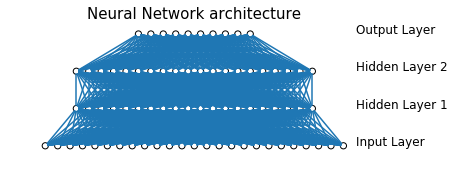

In [30]:
network = DrawNN( [25, 20 , 20 , 10] )
network.draw()

The input layer has 728 elements, which we scaled down to 25 in the above diagram, this feeds into 20 neurons in the hidden layer 1, which serves as the inputs to a 20-neuron hidden layer 2, which are then fed into the 10-dimensional output layer. The classifier essentially finds the index of that output with the maximum value and declares that the digit it has been classified as. As we train the model, the error is reduced via some gradient descent method, and each node/neuron is some activation function, in this case the hyperbolic tangent, while each edge represents a weight W_i. The goal of this neural network is to change the weights W and biases b such that the error between what is found in the output layer versus the tru labels from y_train is minimized.

We then test our test data set by using the model to predict the correct digit. We compare this against the ground truth.

In [35]:
y_predicted = MLP.predict(X_test)
print(y_predicted)
print(y_test)
accuracy = sum(y_test == y_predicted)/float(len(y_test))
print(accuracy)

[ 3.  3.  9. ...,  3.  8.  3.]
[ 5.  3.  9. ...,  3.  8.  3.]
0.902034632035


We see that this network attains ~90% accuracy, which is actually pretty good.

In my next example, I'll show you how you can visualize these digits in 3 dimensions. We'll plot these digits using PCA and TSNE, and show how the predicted digits compare to what was actually written.

TSNE EXAMPLE IS IN DEVELOPMENT!!!

Now that we've given a brief intro to neural networks, let's discuss Genetic Algorithms!

So what is a genetic algorithm?

Let's play with some word associations..

Algorithm.. you probably know that one.

Genetic, genes, evolution? *Darn, not another biology lesson...* you might be thinking.

Not a bad thought. I don't blame you. You're last bio class was probably high school or freshman year of college (mine was freshman year of high school, and now I'm a genomics ML researcher, go figure!). 

So we won't think too hard about the biology. Let's keep it easy.

Some initial pages to consult: 
* https://towardsdatascience.com/introduction-to-genetic-algorithms-including-example-code-e396e98d8bf3
* https://www.analyticsvidhya.com/blog/2017/07/introduction-to-genetic-algorithm/

So a genetic algorithm has a few key components:
1. Population
2. Fitness
3. Selection/Die-off
4. Crossover
5. Mutation

1. Population- As you may know, a *population* is comprised of individuals, which all have attributes, height, jaw size, vocal speech patterns, weight, number of instagram followers, etc....
    * These attributes can cause an individual to be successful or failure, its ability to reproduce and survive.
    
2. We can assign an individual's ability to survive as it's level of *fitness*, it's ability to perform a certain task.

3. The best performing individuals' attributes are *selected* for reproduction, their attributes live on to future generations while other individuals that have low fitness scores *die-off*.

4. Some *selected* individuals with different but promising traits may have their attributes *crossover*, meaning that future generations will have a combination of their traits. This is your time to think of any hollywood super couple.

5. And other high fitness individuals may undergo spontaneous *mutation*, their traits did not mix with other well performing individuals, there was just some arbitrary change which may lead to positive or negative fitness.

With these principles do we form the basis of this algorithm:
1. Initialize a population with random different traits.
2. Test the population against some task and assign fitness scores.
3. Select the most fit individuals for the next generation.
4. Cross over some of the selected individuals.
5. Mutate other selected individuals. 
6. Mutations and crossovers occur at a certain rate identified by the user, or some ML algorithm. The number of individuals in a population is also assigned as well as the method for identifying fitness. Also, at this point, with mutations comes the selection of a few new random individuals for the next generation.
7. With the new population's next generation established, perform steps 1-6 on this population and do this for a few more generations until you have the best performing individual.
8. The best performing individual is the closest you'll get to solving the problem you want to solve, although due to the random nature of this algorithm, you may get better results on other runs. It's an approximated but faster solution compared to other algorithms/searches/maximizations.

How can we use GAs? A few quick examples:
* Maximize/minimize a function
* Train a neural network
* Scan a hyperparameter space, like a bunch of inputs to a program, quickly that could not normally be found in any reasonable amount of time

Say there are 20 different inputs with millions of choices for each input. A GA makes a few random guesses about what the best input choices are, and then iteratively makes more educated guesses about the solution.

So let's get started. Let's use code from the Repo [sklearn-deap](https://github.com/rsteca/sklearn-deap) to implement genetic algorithms:

Here's a simple function we can maximize using scipy's optimization routine or some grid search:

In [2]:
from evolutionary_search import maximize
from scipy.optimize import minimize
import timeit
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np, pandas as pd

f = lambda x,y: -((x-2)**2 + (y-3)**2)
x,y = np.meshgrid(np.linspace(-5.,5.,100),np.linspace(-5.,5.,100))
z = f(x,y)

In [3]:
trace = go.Mesh3d(x=x.flatten(),y=y.flatten(),z=z.flatten(),color='blue')
py.iplot([trace])

Scipy optimize will maximize this function in about 16 iterations using an algorithm that essentially finds the gradient of the function f at an initialized point, and travels a number of steps in the direction that maximizes the directional derivative, or the slope, and repeats this process until convergence. We see this below:

In [9]:
maximization_result = minimize(lambda params: f(*params)*-1,[0,0])
print(maximization_result)
if maximization_result.success:
    fitted_params = maximization_result.x
    print(fitted_params)

      fun: 1.84598775337616e-16
 hess_inv: array([[ 0.84615384, -0.23076923],
       [-0.23076923,  0.65384615]])
      jac: array([ -6.68356037e-09,  -1.60625824e-09])
  message: 'Optimization terminated successfully.'
     nfev: 16
      nit: 3
     njev: 4
   status: 0
  success: True
        x: array([ 1.99999999,  2.99999999])
[ 1.99999999  2.99999999]


We know it maximizes at x=2 and y=3, so we've done a good job here with scipy. Let's try doing this with a genetic algorithm.

In [10]:
individuals = []
def score_f_save(x,y):
    z = f(x,y)
    individuals.append((x,y,z))
    return z

best_params, best_score, score_results, hist, log = maximize(
    score_f_save,dict(x=np.linspace(-5,5,10000),y=np.linspace(-5,5,10000)),{},verbose=True,
    generations_number=5, gene_mutation_prob=0.45, 
    gene_crossover_prob = 0.45, population_size = 70)

genetic_algorithm_results = pd.DataFrame(individuals,columns=['x','y','z'])
genetic_algorithm_results['generation'] = 0
genetic_algorithm_results['individual'] = genetic_algorithm_results.index
generations = []
count = 0
for i, generation in enumerate(log):
    genetic_algorithm_results.loc[count:count+generation['nevals'],'generation'] = i
    count+=generation['nevals']
print(genetic_algorithm_results)

Types [2, 2] and maxint [9999, 9999] detected
--- Evolve in 100000000 possible combinations ---
gen	nevals	avg     	min    	max      	std    
0  	70    	-30.0485	-109.93	-0.793102	23.6208
1  	46    	-13.9508	-75.8753	-0.793102	14.1463
2  	47    	-7.34991	-46.8619	-0.061428	9.6095 
3  	35    	-4.28484	-66.0566	-0.061428	8.81626
4  	38    	-2.13876	-42.4449	-0.061428	5.87506
5  	41    	-1.83529	-43.5406	-0.061428	6.7878 
Best individual is: {'x': 1.996699669966997, 'y': 3.2478247824782471}
with fitness: -0.0614280149887
            x         y          z  generation  individual
0    3.794879 -3.431843 -44.590199           0           0
1   -4.899990  1.774677 -49.111277           0           1
2    3.702870 -2.981798 -38.681677           0           2
3    3.750875  4.568957  -5.527189           0           3
4    2.977798 -2.506751 -31.280391           0           4
5   -4.521952 -3.953895 -90.892522           0           5
6    0.921592 -3.790879 -47.279002           0           6
7   

In [12]:
plots = []
plots2 = []
for gen in genetic_algorithm_results['generation'].unique():
    df = genetic_algorithm_results[genetic_algorithm_results['generation'] == gen]
    plots.append(go.Scatter3d(x=df['x'],y=df['y'],z=df['z'],mode='markers',marker=dict(size=2),text=df['individual'],name='Generation %d'%gen))
    plots2.append(go.Scatter(x=df['individual'],y=df['z'],text='x: ' + df['x'].map(str) + ', y: ' + df['y'].map(str),name='Generation %d'%gen))
py.iplot(plots)
py.iplot(plots2) 

The genetic algorithm does not perform as well. Via sklearn-deap's maximize function, it performs the aforementioned genetic algorithm steps, and I chose to take the best x and y values by the time it reaches its fifth generation. The GA chose 70 random points to begin with, and then at every generation, made guesses that it thought would bring it closer to the maximum via evolutionary rules. Select different generations in the above display by clicking on labels in the legend. You see that every generation gets closer to the solution. It is a little less accurate than scipy's optimize and took more iterations (270). But this example gives you an idea about how these things work.

Generation 1's points are interspersed, successive generations get closer to the mark via selection, crossover, and mutation. An individual in the population is represented by coordinates (x,y); we can say that it contains genes x and y, and these sets of genes are selected for, crossover (like finding the midpoint or interchanging with another specimen), and mutate.

The performance is bad here because we are looking at simple functions in lower dimensions. Scipy's optimization routine will not perform as well in higher dimensions with more complex models and functions. Far more datapoints and evaluations would be needed, something that a GA would thrive at.

I'll focus the rest of this tutorial on using GA's to tune machine learning algorithms to attain the best results.

ADD MORE HERE!! Figure out how to get plotly to work with Github. Also add example varying z versus generation and individual, and show xy values... like in dash app

TODO:
TSNE and PCA explanation
Genetic algorithm
* varying weights via GA vs backprop
* use backprop/gradient descent, but use GA to change neural network architecture (number of hidden layers, size of each hidden layer, etc... final output will be neural network hidden layer sizes, built from running GA on hidden layers number, which in turn are GAs of hidden layer sizes, each train test, maybe use CV as a test for training)